In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8-whitegrid")

df_hourly = pd.read_csv("wroclaw_ml_hourly.csv", parse_dates=["time"], index_col="time")
df_hourly = df_hourly.sort_index()

In [3]:
from baseline_daily_predictions import prep_data, evaluate_model

In [4]:
# Data Preparation
df_daily = prep_data()

# Split (Test = Last 365 Days)
last_timestamp = df_daily.index.max()

cutoff_date = last_timestamp - pd.Timedelta(days=365)

train = df_daily[df_daily.index <= cutoff_date]
test = df_daily[df_daily.index > cutoff_date].copy()

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")

Train set: 2005-01-01 to 2025-01-17
Test set: 2025-01-18 to 2026-01-17


In [5]:
def add_yearly_cyclical_features(df):
    day_of_year = df.index.dayofyear
    df = df.copy()
    df["doy_sin"] = np.sin(2 * np.pi * day_of_year / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * day_of_year / 365.25)
    return df


train = add_yearly_cyclical_features(train)
test = add_yearly_cyclical_features(test)

exog_cols = ["doy_sin", "doy_cos"]


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def train_and_predict_sarimax(
    train_df,
    test_df,
    target_col,
    exog_cols,
    model_name,
):
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    exog_train = train_df[exog_cols]
    exog_test = test_df[exog_cols]

    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=(1, 1, 1),
        seasonal_order=(0, 0, 0, 365),  # sezonowość przez exog
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    result = model.fit(disp=False, maxiter=50)

    forecast = result.get_forecast(
        steps=len(test_df),
        exog=exog_test,
    )

    y_pred = forecast.predicted_mean

    print(f"\n=== {model_name} ({target_col}) ===")
    print(result.summary().tables[1])

    return y_pred, result


In [14]:
# ===== DAY =====
pred_day_sarimax, res_day = train_and_predict_sarimax(
    train,
    test,
    target_col="target_temp_day",
    exog_cols=exog_cols,
    model_name="SARIMAX Day",
)

# ===== NIGHT =====
pred_night_sarimax, res_night = train_and_predict_sarimax(
    train,
    test,
    target_col="target_temp_night",
    exog_cols=exog_cols,
    model_name="SARIMAX Night",
)



=== SARIMAX Day (target_temp_day) ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
doy_sin       -2.7678      0.190    -14.586      0.000      -3.140      -2.396
doy_cos      -10.7439      0.186    -57.746      0.000     -11.109     -10.379
ar.L1          0.7497      0.007    100.366      0.000       0.735       0.764
ma.L1         -1.0028      0.001  -1087.594      0.000      -1.005      -1.001
sigma2         7.6042      0.113     67.140      0.000       7.382       7.826

=== SARIMAX Night (target_temp_night) ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
doy_sin       -2.8223      0.150    -18.832      0.000      -3.116      -2.529
doy_cos       -8.5706      0.146    -58.801      0.000      -8.856      -8.285
ar.L1          0.6676      0.008     85.613      


--- SARIMAX (Yearly Seasonality) ---
[Day  ] RMSE: 4.18, MAE: 3.40, R2: 0.76
[Night] RMSE: 3.84, MAE: 3.06, R2: 0.72


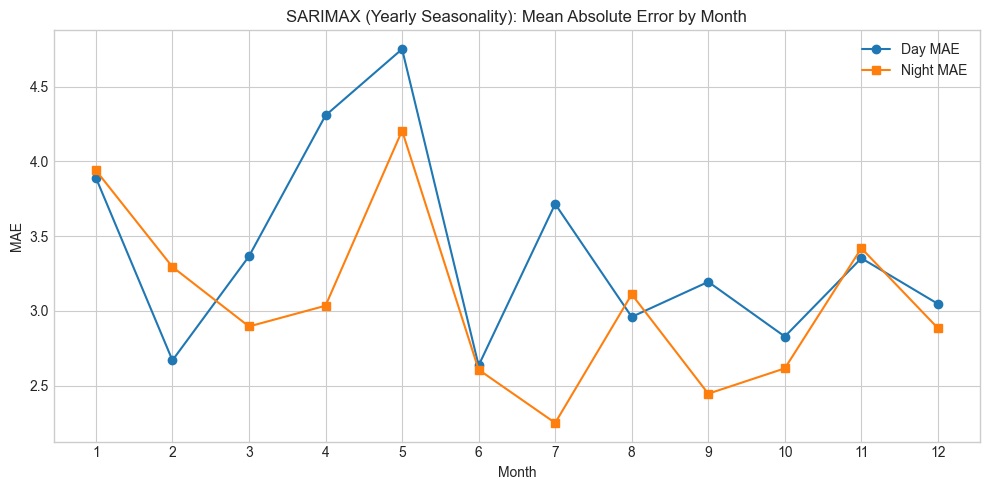

In [15]:
evaluate_model(
    test["target_temp_day"],
    pred_day_sarimax,
    test["target_temp_night"],
    pred_night_sarimax,
    "SARIMAX (Yearly Seasonality)",
)


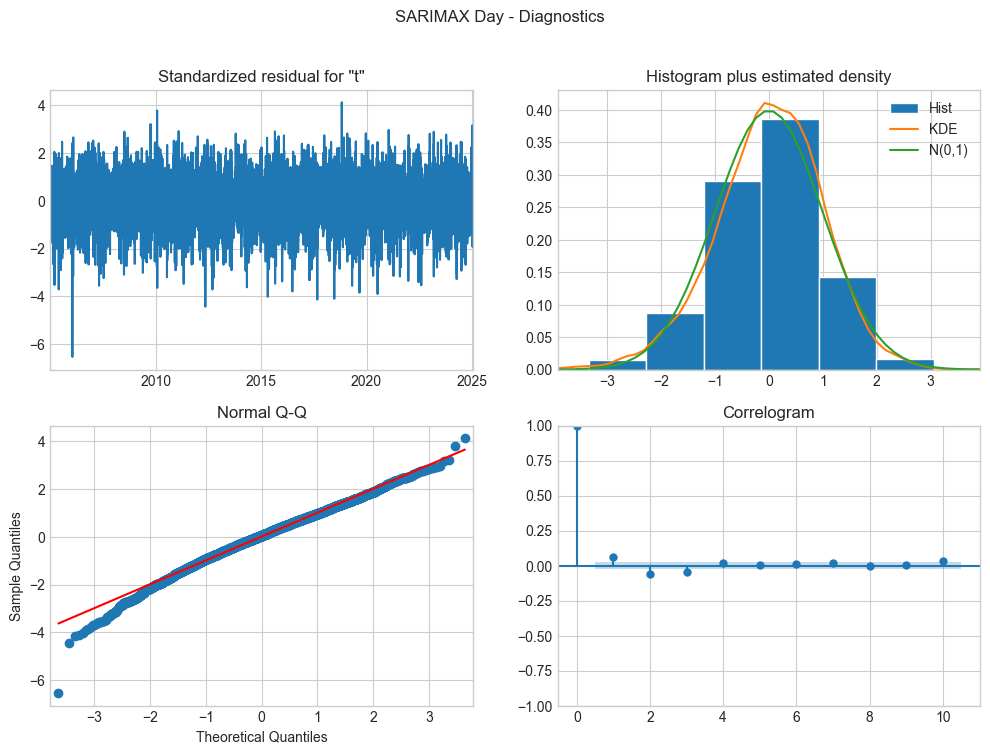

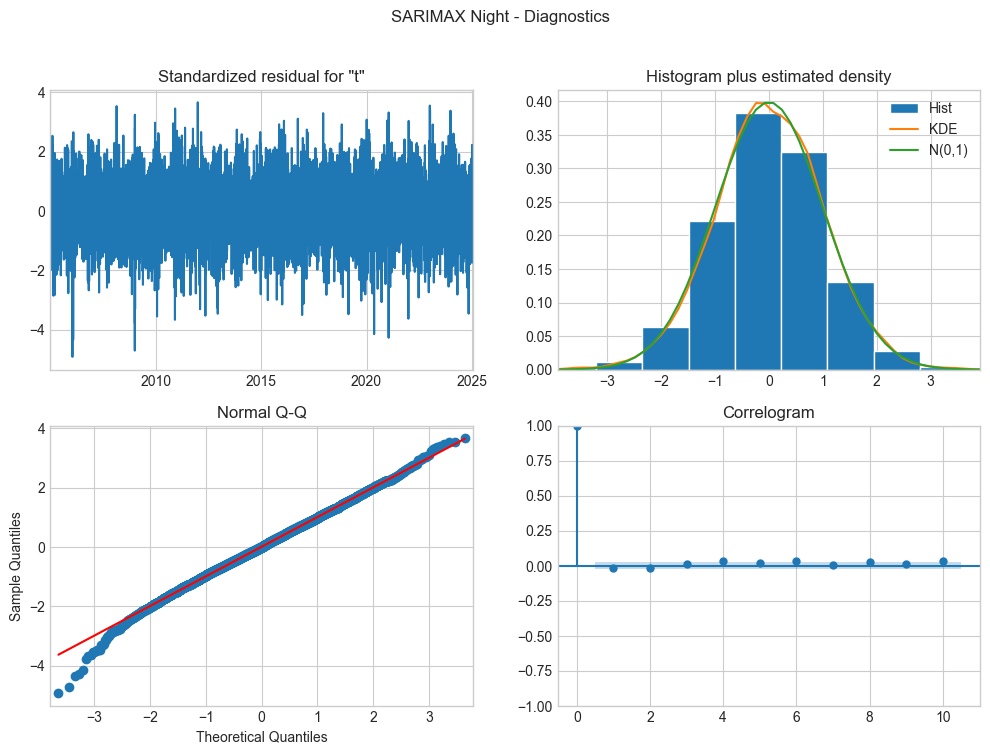

In [16]:
res_day.plot_diagnostics(figsize=(12, 8))
plt.suptitle("SARIMAX Day - Diagnostics")
plt.show()

res_night.plot_diagnostics(figsize=(12, 8))
plt.suptitle("SARIMAX Night - Diagnostics")
plt.show()
